# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science

## Standard Section 6: Logistic Regression and PCA

**Harvard University**<br/>
**Fall 2017**<br/>
**Section Leaders:** Mehul Smriti Raje, Ken Arnold, Karan Motwani, Cecilia Garraffo<br/>
**Instructors:** Pavlos Protopapas, Kevin Rader

In this section we will be covering Logistic Regression and PCA using the Wine dataset. The goal is to get you familiarized with the implementation of Logistic Regresison and PCA through the use of a dataset we haven't seen. The exercises below will help you be able to answer parts of Homework 5.

Specifically, we will: 
    
    1. Import data, explore with analyse relationship with response.
    2. Fit a linear regression model for classification, understand drawbacks and interpret results.
    3. Fit a logistic regression model for classification, compare performance and interpret results.
    3. Use PCA to reduce dimensionality, fit model to PCA components and compare performance.


For this section we will be using the following packages:

In [5]:
# Data and Stats packages
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn import metrics, datasets
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler

# Visualization packages
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.rcParams['figure.figsize'] = (13.0, 6.0)

# Other
import itertools
import tqdm

# Aesthetic settings
from IPython.display import display
pd.set_option('display.max_columns', 999)
pd.set_option('display.width', 500)
sns.set_style('whitegrid')
sns.set_context('talk')

# Part One

## Import Dataset

In [8]:
#Import dataframe
flowers_df = pd.read_csv('data/flowers.csv')
del flowers_df['Unnamed: 0']
display(flowers_df.head())

,sepal_length,sepal_width,petal_length,petal_width,species
0,7.0,3.2,4.7,1.4,versicolor
1,6.4,3.2,4.5,1.5,versicolor
2,6.9,3.1,4.9,1.5,versicolor
3,5.5,2.3,4.0,1.3,versicolor
4,6.5,2.8,4.6,1.5,versicolor


As we can see, `species` here is the response variable which defines flower type and the 4 predictor variables are flower characteristics. 

In [9]:
#Describe dataset
flowers_df['species'] = flowers_df['species'] == 'versicolor'
display(flowers_df.describe())

,sepal_length,sepal_width,petal_length,petal_width
count,100.000000,100.000000,100.000000,100.000000
mean,6.262000,2.872000,4.906000,1.676000
std,0.662834,0.332751,0.825578,0.424769
min,4.900000,2.000000,3.000000,1.000000
25%,5.800000,2.700000,4.375000,1.300000
50%,6.300000,2.900000,4.900000,1.600000
75%,6.700000,3.025000,5.525000,2.000000
max,7.900000,3.800000,6.900000,2.500000


## Explore Data 

Check which variables have high correlations and distinctive patterns with the response. Any patterns worth mentioning?

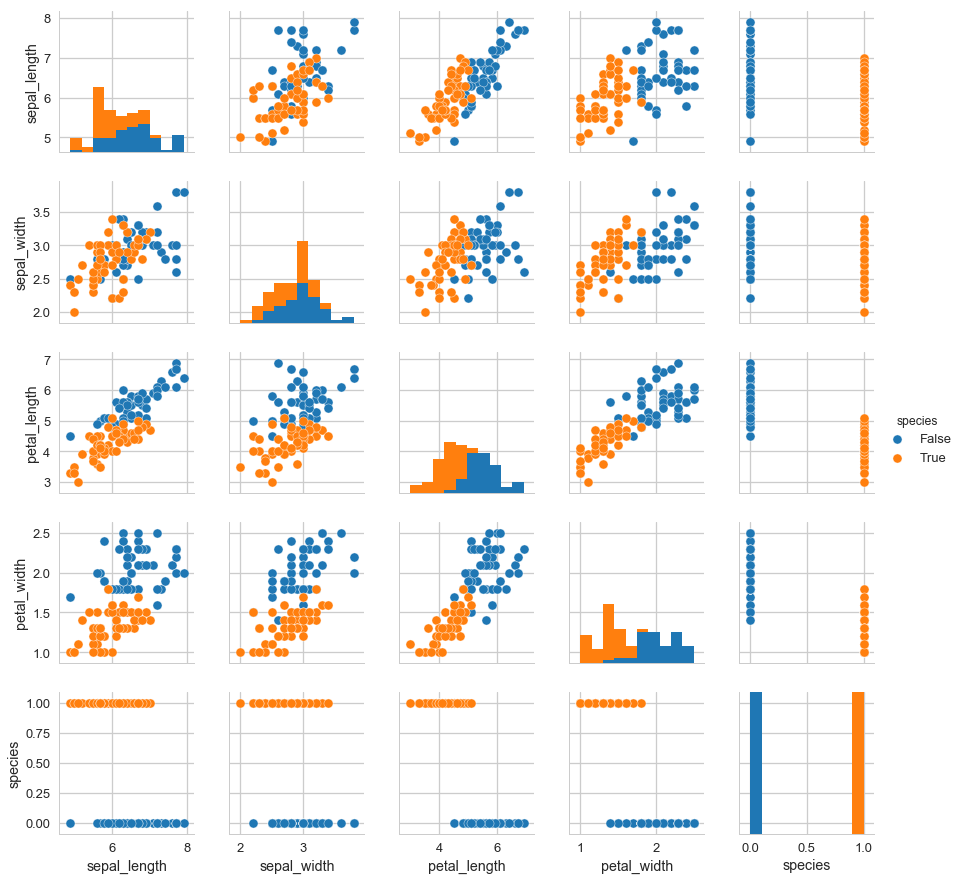

In [10]:
sns.pairplot(flowers_df, hue="species")
plt.show()

#### This plot is great because it not only shows correlations but also relationship with the response. The left diagonal shows the histogram for each predictor with the response subset. You can re-create the left diagonal with the code below.

/Users/pwong/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/pwong/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/pwong/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/pwong/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/pwong/anaconda3/lib/python3.6

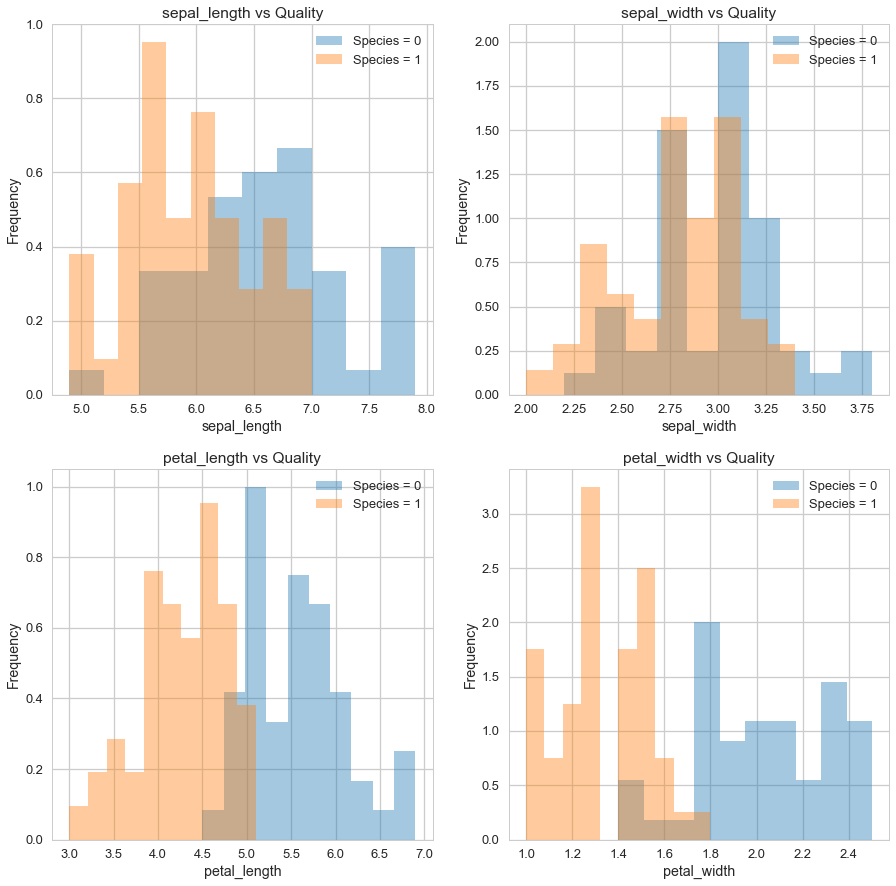

In [11]:
#Explore dataset for relationships with Quality
subset_species_0, subset_species_1 = flowers_df[flowers_df['species'] == 0], flowers_df[flowers_df['species'] == 1]

#Get set of predictors
columns = list(flowers_df.columns)
columns.remove('species')

#Plot relationship
fig, ax = plt.subplots(2, 2, figsize=(15, 15))
alpha = 0.4
count = 0
for i in range(2):
    for j in range(2):
        ax[i, j].hist(subset_species_0[columns[count]], alpha=alpha, label='Species = 0', normed=True)
        ax[i, j].hist(subset_species_1[columns[count]], alpha=alpha, label='Species = 1', normed=True)
        ax[i, j].set_title(columns[count]+' vs Quality')
        ax[i, j].set_xlabel(columns[count])
        ax[i, j].set_ylabel('Frequency')
        ax[i, j].legend()
        count += 1
plt.show()

We can observe that `petal_length`, `petal_width` are useful distinguishing predictors for flower species.

## Split and Normalize Data

In [12]:
#Split data into train and test
np.random.seed(1001)
msk = np.random.rand(len(flowers_df)) < 0.7
data_train = flowers_df[msk]
data_test = flowers_df[~msk]

#Split predictor and response columns
x_train, y_train = data_train.drop(['species'], axis=1), data_train['species']
x_test, y_test = data_test.drop(['species'], axis=1), data_test['species']

print("Length of Training Set :",len(data_train))
print("Length of Testing Set :",len(data_test))

Length of Training Set : 64
Length of Testing Set : 36


### What is the right way to normalize?

In [14]:
x_train.head()

,sepal_length,sepal_width,petal_length,petal_width
0,0.700000,0.6250,0.435897,0.266667
1,0.500000,0.6250,0.384615,0.333333
2,0.666667,0.5625,0.487179,0.333333
3,0.200000,0.0625,0.256410,0.200000
4,0.533333,0.3750,0.410256,0.333333


In [13]:
#Function to normalize data 
def normalize(df, train_dict, flag=True):
    for i in df.columns:
        if flag:
            train_dict[i] = (df[i].min(), df[i].max())
        df[i] = (df[i] - train_dict[i][0]) / (train_dict[i][1] - train_dict[i][0])
    return df, train_dict

#Normalize train and get characteristics of training columns
x_train, train_dict = normalize(x_train, {}, True)
x_test, train_dict = normalize(x_test, train_dict, False)

Peeking at any information from the test set is cheating, we use the entire dataset for atmost data exploration. No information, including min, max, mean std, should be used from the test set or under the influence of the test set. Thus, the right way to normalize is to store the characteristics of the training set and apply it to both datasets independently.

In [8]:
print("Training Dataframe :")
display(x_train.describe())
print("\n\nTesting Dataframe :")
display(x_test.describe())

Training Dataframe :


,sepal_length,sepal_width,petal_length,petal_width
count,64.000000,64.000000,64.000000,64.000000
mean,0.442187,0.416992,0.466747,0.414583
std,0.223429,0.195451,0.213806,0.285936
min,0.000000,0.000000,0.000000,0.000000
25%,0.266667,0.312500,0.307692,0.200000
50%,0.466667,0.437500,0.435897,0.333333
75%,0.575000,0.500000,0.602564,0.666667
max,1.000000,1.000000,1.000000,1.000000




Testing Dataframe :


,sepal_length,sepal_width,petal_length,petal_width
count,36.000000,36.000000,36.000000,36.000000
mean,0.475000,0.425347,0.527778,0.514815
std,0.217981,0.231368,0.204979,0.270267
min,0.000000,-0.125000,0.128205,0.000000
25%,0.358333,0.296875,0.384615,0.316667
50%,0.450000,0.437500,0.525641,0.533333
75%,0.600000,0.562500,0.666667,0.733333
max,0.933333,1.000000,0.948718,1.000000


Some maximum values in Testing Dataframe are not 1, some minimum values are > 0. 
Is this wrong? What could be an explanation for this? Could we see negative values in test or values greater than 1?

# Part Two

## Perform Classification using Multiple Linear Regression

In [9]:
#Add constant to x_train and x_test
x_train_cst = sm.add_constant(x_train)
x_test_cst = sm.add_constant(x_test)

#Training
model = OLS(y_train, x_train_cst).fit()

#Predict
y_pred_train = model.predict(x_train_cst)>0.5
y_pred_test = model.predict(x_test_cst)>0.5

#Perfromance Evaluation
train_score = accuracy_score(y_train, y_pred_train)*100
test_score = accuracy_score(y_test, y_pred_test)*100

print("Training Set Accuracy:",str(train_score)+'%')
print("Testing Set Accuracy:",str(test_score)+'%')

Training Set Accuracy: 98.4375%
Testing Set Accuracy: 94.44444444444444%


In [10]:
#Get significant predictors and Confidence Intervals using Stats Model Summary
print("Significant Predictors :\n",)
print(model.pvalues[model.pvalues<0.01],"\n")

thresh = 0.01
intervals = model.conf_int(alpha=thresh)
intervals = intervals.rename(index=str, columns={0:str(thresh/2*100)+"%",1:str((1-thresh/2)*100)+"%"})
print("Confidence Intervals:",)
display(intervals)

Significant Predictors :

const          1.302238e-21
petal_width    1.368759e-06
dtype: float64 

Confidence Intervals:


,0.5%,99.5%
const,1.021095,1.466538
sepal_length,-0.493553,1.000970
sepal_width,-0.115400,0.921418
petal_length,-2.049886,0.164881
petal_width,-1.768611,-0.597113


Here, we have used a higher probability threshold (p<0.01) since we have very few datapoints. Does this make sense?

`petal_width` seems like the only significant predictor, is this intuitive given the histogram above?

In [11]:
#Get Performance by Class (Lookup Confusion Matrix)
pd.crosstab(y_test, y_pred_test, margins=True, rownames=['Actual'], colnames=['Predicted'])

Predicted,False,True,All
Actual,,,
False,22,2,24
True,0,12,12
All,22,14,36


Can you calculate True Positive Rate? False Positive Rate? 

If this was a medical test for cancer, what do we want ideally, Low False Positive rate or Low False Negative rate? What are the implications?

# Part Three

## Perform Classification using Multiple Logistic Regression

[https://towardsdatascience.com/logistic-regression-detailed-overview-46c4da4303bc]

In [12]:
#Add constant to x_train and x_test
x_train_cst = sm.add_constant(x_train)
x_test_cst = sm.add_constant(x_test)

#Training
model = LogisticRegression(C=100000).fit(x_train_cst, y_train)

#Predict
y_pred_train = model.predict(x_train_cst)
y_pred_test = model.predict(x_test_cst)

#Perfromance Evaluation
train_score = accuracy_score(y_train, y_pred_train)*100
test_score = accuracy_score(y_test, y_pred_test)*100

print("Training Set Accuracy:",str(train_score)+'%')
print("Testing Set Accuracy:",str(test_score)+'%')

Training Set Accuracy: 100.0%
Testing Set Accuracy: 86.11111111111111%


In [13]:
#Get Performance by Class 
pd.crosstab(y_test, y_pred_test, margins=True, rownames=['Actual'], colnames=['Predicted'])

Predicted,False,True,All
Actual,,,
False,20,4,24
True,1,11,12
All,21,15,36


In [14]:
#Helper function for visualization
def visualize_prob(model, x, y, ax):
    """
    Function Name : visualize_prob
    Description : A function to visualize the probabilities predicted by a Logistic Regression model
    Input: 
       model (Logistic regression model)
       x (n x d array of predictors in training data)
       y (n x 1 array of response variable vals in training data: 0 or 1)
       ax (an axis object to generate the plot)
    """
    
    #Use the model to predict probabilities for x
    y_pred = model.predict_proba(x)
    
    #Separate the predictions on the label 1 and label 0 points
    ypos = y_pred[y==1]
    yneg = y_pred[y==0]
    
    #Count the number of label 1 and label 0 points
    npos = ypos.shape[0]
    nneg = yneg.shape[0]
    
    #Plot the probabilities on a vertical line at x = 0, 
    #with the positive points in blue and negative points in red
    pos_handle = ax.plot(np.zeros((npos,1)), ypos[:,1], 'bo', label = 'Species 1', alpha=0.2)
    neg_handle = ax.plot(np.zeros((nneg,1)), yneg[:,1], 'ro', label = 'Species 0', alpha=0.2)

    #Line to mark prob 0.5
    ax.axhline(y = 0.5, color = 'k', linestyle = '--')
    
    #Add y-label and legend, do not display x-axis, set y-axis limit
    ax.set_ylabel('Probability of Species Class')
    ax.legend(loc = 'best')
    ax.get_xaxis().set_visible(False)

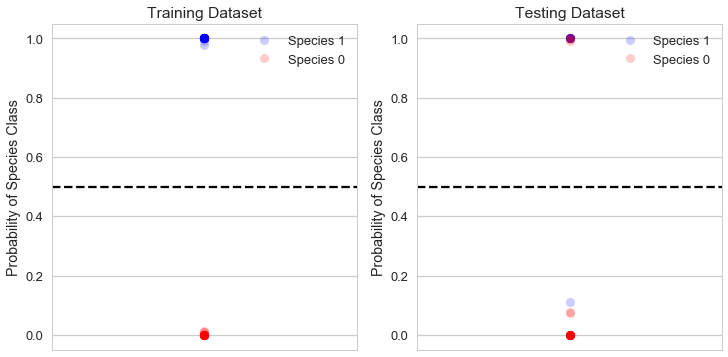

In [15]:
#Create Plot
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

#Plot Training
visualize_prob(model, x_train_cst, y_train, ax1)
ax1.set_title('Training Dataset')

#Plot Testing
visualize_prob(model, x_test_cst, y_test, ax2)
ax2.set_title('Testing Dataset')
plt.show()

Does Logistic Regression perform better or worse? Has it overfitted to the training set? What would points near 0.5 line mean?

## Analyzing Significance of Coefficients

How many of the coefficients estimated by the multiple logistic regression model are significantly different from zero at a *significance level of 95%*? 

[https://www.sagepub.com/sites/default/files/upm-binaries/21122_Chapter_21.pdf]

In [16]:
#Creating model
model = LogisticRegression(C=100000)

#Initializing variables
bootstrap_iterations = 1000
coeffs = np.zeros((bootstrap_iterations, data_train.shape[1]-1))

#Conduct bootstraping iterations
for i in range(bootstrap_iterations):
    temp = data_train.sample(frac=1, replace=True)
    response_variable = temp['species']
    temp = temp.drop(['species'], axis=1)
    model.fit(temp, response_variable)  
    coeffs[i,:] = model.coef_    

#Find Significant Columns, Count
coeffs_count, significant_cols = 0, []
for i in range(coeffs.shape[1]):
    coeff_samples = coeffs[:,i]
    lower_bound = np.percentile(coeff_samples, 2.5)
    upper_bound = np.percentile(coeff_samples, 97.5) 
    if lower_bound>0 or upper_bound<0:
        coeffs_count += 1
        significant_cols.append(data_train.columns[i])
    
print('Columns :', significant_cols)
print('Count of 95% statistically significant coefficients :', coeffs_count)

Columns : ['petal_width']
Count of 95% statistically significant coefficients : 1


# Part Four

## - Use PCA to Reduce Dimensionality 
## - Perform Classification on PCA Components

Although PCA is used for dimensionality reduction, let's apply it to this problem. Find the number of principal components needed to explain 85% of the data variance and compare the performance of the model fitted to this data.

In [21]:
#Create and fit PCA object
pca = PCA()
pca.fit(x_train)

#Transforming x_train and x_test 
x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)

#Find number of components that explain predefined variance threshold
sum_variance, component_count = 0, 0
while sum_variance < 0.85:
    sum_variance += pca.explained_variance_ratio_[component_count]
    component_count += 1
    
print('Number of Principal Components that explain >=85% of Variance: ', component_count)
print('Total Variance Explained by '+str(component_count)+' components:', str(sum_variance*100)+'%')

Number of Principal Components that explain >=85% of Variance:  2
Total Variance Explained by 2 components: 88.42744186872083%


In [18]:
#Create and fit PCA object
pca = PCA(n_components=component_count)
pca.fit(x_train)

#Transforming x_train and x_test 
x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)

#Add constant to x_train and x_test
x_train_pca_cst = sm.add_constant(x_train_pca)
x_test_pca_cst = sm.add_constant(x_test_pca)

#Training
model = LogisticRegression(C=100000).fit(x_train_pca_cst, y_train)

#Predict
y_pred_train = model.predict(x_train_pca_cst)
y_pred_test = model.predict(x_test_pca_cst)

#Perfromance Evaluation
train_score = accuracy_score(y_train, y_pred_train)*100
test_score = accuracy_score(y_test, y_pred_test)*100

print("Training Set Accuracy:",str(train_score)+'%')
print("Testing Set Accuracy:",str(test_score)+'%')

Training Set Accuracy: 100.0%
Testing Set Accuracy: 86.11111111111111%


We observe that 2 PC's were enough to replicate the accuracy performance of Logistic Regression with all predictors. Imagine the impact to complexity we can cause when we have multiple thousand predictors but few PCA components are able to able to match their performance. Drawback? Interpretability.

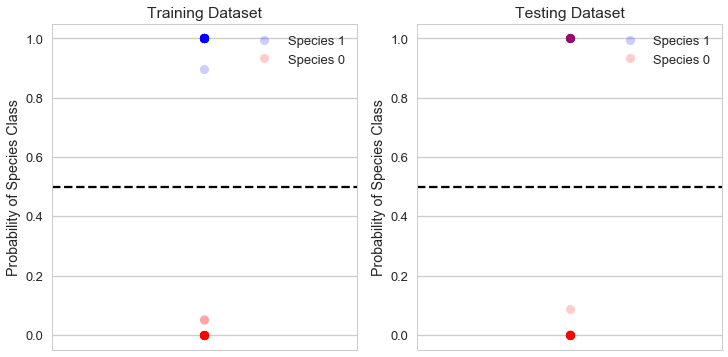

In [19]:
#Create Plot
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

#Plot Training
visualize_prob(model, x_train_pca_cst, y_train, ax1)
ax1.set_title('Training Dataset')

#Plot Testing
visualize_prob(model, x_test_pca_cst, y_test, ax2)
ax2.set_title('Testing Dataset')
plt.show()

In [20]:
#Get Performance by Class
pd.crosstab(y_test, y_pred_test, margins=True, rownames=['Actual'], colnames=['Predicted'])

Predicted,False,True,All
Actual,,,
False,20,4,24
True,1,11,12
All,21,15,36


Where does PCA perform better/worse? Does trying to explain variance sacrifice the power of the predictors? Is the variance we ignore, the last 15%, better for generalizability of the model i.e. can it prevent overfitting to the training set?

[https://giphy.com/gifs/pca-Lyejb62QjQepG]